In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Project1/data_project1.zip" -d '/content/'

Archive:  /content/drive/MyDrive/Project1/data_project1.zip
  inflating: /content/data.csv       


In [ ]:
!pip install pyprind

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os 
import cv2
import numpy as np 
import pandas as pd
import csv
import datetime
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, KFold,StratifiedKFold 
import pyprind
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = []
datetime_object = datetime.date.today()
print ('datetime_object',datetime_object)
data = pd.read_csv('/content/data.csv')
print ('data',data.head(4))

datetime_object 2022-10-21
data    label                                              image
0    Bản  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
1   chất  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
2    của  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....
3  thành  0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0....


In [ ]:
labels = []
images = []

labels = data.iloc[: ,0].to_list()
images = data.iloc[: ,1].to_list()
print ('\nThe number of data', len(labels))
max_str_len = max([len(str(label)) for i,label in enumerate(labels)])
print ('max_str_len',max_str_len)


The number of data 110746
max_str_len 11


In [ ]:
count = 0
for i, label in enumerate(labels):
    if type(label) == float:
        del labels[i]
        del images[i]
        count +=1
print ('The number of invalid data:',count)
print ('The number of valid data left:',len(labels))

The number of invalid data: 12
The number of valid data left: 110734


In [ ]:
t = []
for i,image in enumerate(images):
    image = np.array(image.split(' '), dtype = float)
    t.append(image)
images = []

In [ ]:
images = t
t = []
print ('len images', len(images))

len images 110734


In [ ]:
images = np.array(images).reshape(-1, 128, 32, 1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(images, labels, train_size= 0.85, shuffle = True)

images = []
labels = []

print ('\nlen(X_train)',len(X_train))
print ('len(X_valid)',len(X_valid))
print ('\n X_train.shape',X_train.shape)
print ('\n X_valid.shape',X_valid.shape)


len(X_train) 94123
len(X_valid) 16611

 X_train.shape (94123, 128, 32, 1)

 X_valid.shape (16611, 128, 32, 1)


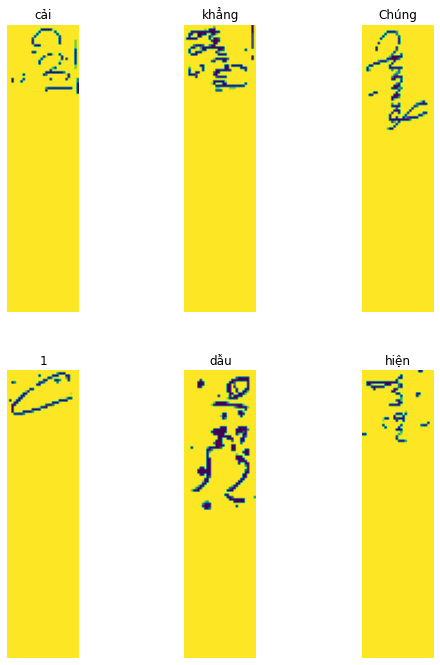

In [ ]:
import matplotlib.pyplot as plt

plt.figure(num='char',figsize=(9,18))
for i in range(6):
    rand = random.randint(0, len(X_train))
    plt.subplot(3,3,i+1) 
    plt.title(y_train[rand])
    plt.imshow(np.squeeze(X_train[rand,:,:,]))
    plt.axis('off')
plt.show()

In [ ]:
alphabets = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvxyzÀÁÂÔÚÝàáâãèéêìíòóôõùúýĂăĐđĩũƒƠơƯưạẢảẤấẦầẩẫậắằẳẵặẹẻẽếỀềỂểễỆệỉịọỏỐốỒồổỗộớờỞởỡợụỦủứừửữựỳỷỹ'
print ('the number of characters:', len(alphabets))
num_of_characters = len(alphabets) + 1 
num_of_timestamps = 31


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:
            break
        else:
            ret+=alphabets[ch]
    return ret

the number of characters: 147


In [ ]:
train_y = np.ones([len(X_train), max_str_len]) * -1
train_label_len = np.zeros([len(X_train), 1])
train_input_len = np.ones([len(X_train), 1]) * (num_of_timestamps-2)
train_output = np.zeros([len(X_train)])

for i in range(len(X_train)):
    train_label_len[i] = len(y_train[i])
    train_y[i, 0:len(y_train[i])]= label_to_num(y_train[i])  

print ('len train_y',len(train_y))

len train_y 94123


In [ ]:
valid_y = np.ones([len(X_valid), max_str_len]) * -1
valid_label_len = np.zeros([len(X_valid), 1])
valid_input_len = np.ones([len(X_valid), 1]) * (num_of_timestamps-2)
valid_output = np.zeros([len(X_valid)])

for i in range(len(X_valid)):
    valid_label_len[i] = len(y_valid[i])
    valid_y[i, 0:len(y_valid[i])]= label_to_num(y_valid[i])  
    
print ('len valid_y', len(valid_y))

len valid_y 16611


In [ ]:
def build_word_model(alphabets, max_str_len, img_width = 128,img_height = 32):

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    

    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2),strides = 2, name="pool1")(x)

    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), strides = 2, name="pool2")(x)

    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
  

    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)

    x = layers.MaxPooling2D((1, 2), name="pool4")(x)

    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv5",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_1")(x)
    
    x = layers.Conv2D(
        512,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv6",
    )(x)

    x = layers.BatchNormalization(momentum = 0.8, name="BatchNormalization_2")(x)

    x = layers.MaxPooling2D((1, 2), name="pool6")(x)

    x = layers.Conv2D(
        512,
        (2, 2),
        activation="relu",
        kernel_initializer="he_normal",
        padding="valid",
        name="Conv7",
    )(x)



    new_shape = (31,512)

    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    
    def attention_rnn(inputs):

        input_dim = int(inputs.shape[2])
        timestep = int(inputs.shape[1])
        a = layers.Permute((2, 1))(inputs) 
        a = layers.Dense(timestep, activation='softmax')(a) 
        a = layers.Lambda(lambda x: keras.backend.mean(x, axis=1), name='dim_reduction')(a)
        a = layers.RepeatVector(input_dim)(a)
        a_probs = layers.Permute((2, 1), name='attention_vec')(a)
        output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul') 
        return output_attention_mul

    x = attention_rnn(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    y_pred = layers.Dense(len(alphabets) + 1 , activation="softmax", name="last_dense")(x) 
    word_model = keras.models.Model(inputs=input_img, outputs=y_pred, name="functional_1")

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args

        y_pred = y_pred[:, 2:, :]
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

    labels = layers.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    word_model_CTC = keras.models.Model(inputs=[input_img, labels, input_length, label_length], outputs=ctc_loss, name = "ocr_model_v1")
    
    return word_model, word_model_CTC

word_model, word_model_CTC = build_word_model(alphabets = alphabets, max_str_len = max_str_len)
word_model_CTC.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 64)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 128)  73856       ['pool1[0][0]']       

Epoch 1/100
736/736 [==============================] - 265s 335ms/step - loss: 12.2661 - val_loss: 9.0522 - lr: 0.0010
Epoch 2/100
736/736 [==============================] - 236s 320ms/step - loss: 6.9971 - val_loss: 5.3374 - lr: 0.0010
Epoch 3/100
736/736 [==============================] - 239s 325ms/step - loss: 4.4533 - val_loss: 3.6420 - lr: 0.0010
Epoch 4/100
736/736 [==============================] - 234s 318ms/step - loss: 3.0040 - val_loss: 2.7619 - lr: 0.0010
Epoch 5/100
736/736 [==============================] - 237s 322ms/step - loss: 2.2101 - val_loss: 2.2861 - lr: 0.0010
Epoch 6/100
736/736 [==============================] - 239s 326ms/step - loss: 1.7233 - val_loss: 2.1231 - lr: 0.0010
Epoch 7/100
736/736 [==============================] - 237s 322ms/step - loss: 1.3956 - val_loss: 1.9545 - lr: 0.0010
Epoch 8/100
736/736 [==============================] - 233s 317ms/step - loss: 1.1448 - val_loss: 1.8565 - lr: 0.0010
Epoch 9/100
736/736 [==============================] - 

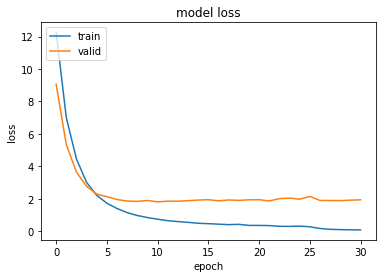

In [ ]:
epochs = 100
batch_size = 128
early_stopping_patience = 20

def scheduler(epoch):
    if epoch <= 25:
        return 1e-3  
    elif 25 < epoch <= 30:
        return 1e-4
    else:
        return 1e-5


my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint(filepath='word_model_{epoch:02d}_'+str(datetime_object)+'.h5', 
                                    save_freq='epoch',
                                    monitor='val_loss',
                                    mode='auto',
                                    save_best_only=True,
                                    period = 5),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]

word_model_CTC.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, 
                    optimizer=keras.optimizers.Adam(),                  
                    )

history = word_model_CTC.fit(x=[X_train, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([X_valid, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs = epochs, 
                batch_size = batch_size,
                callbacks = my_callbacks,
                )


print(history.history.keys())


fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
word_model.save('model.h5')

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):

    m = len(ref)
    n = len(hyp)

    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    distance = np.zeros((2, n + 1), dtype=np.int32)

    for j in range(0,n + 1):
        distance[0][j] = j

    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
  
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
 
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
preds = word_model.predict(X_valid)

decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(len(X_valid)):
    prediction.append(num_to_label(decoded[i]))


y_true = y_valid
correct_char = 0
total_char = 0
correct = 0
test_cer, test_wer = [], []

for i in range(len(X_valid)):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
    test_cer.append(cer(tr, pr))
    test_wer.append(wer(tr, pr))
                  
avg_cer = sum(test_cer)/len(test_cer)   
avg_wer = sum(test_wer)/len(test_wer)

print ('Average CER: %.2f%%' %(avg_cer*100))
print ('Average WER: %.2f%%' %(avg_wer*100))
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/len(X_valid)))

520/520 [==============================] - 17s 29ms/step
Average CER: 14.45%
Average WER: 30.12%
Correct characters predicted : 83.13%
Correct words predicted      : 69.88%


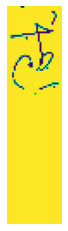

true label tôi
predicted tôi 



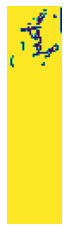

true label đầy
predicted đầy 



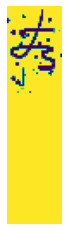

true label thì
predicted thì 



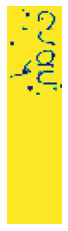

true label chấn
predicted chấn 



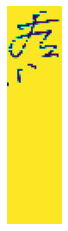

true label thì
predicted thì 



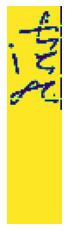

true label tình
predicted tình 



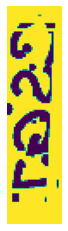

true label CSGT
predicted CSGT 



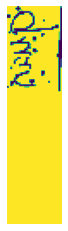

true label quan
predicted quan 



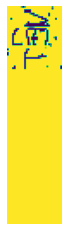

true label VIỆT
predicted IỆt 



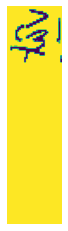

true label vật
predicted vật 



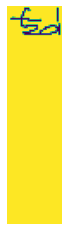

true label ty
predicted ty 



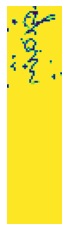

true label giảm
predicted ngiản 



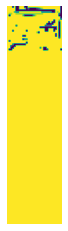

true label lý
predicted là 



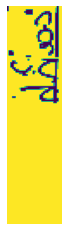

true label cảnh
predicted cảnh 



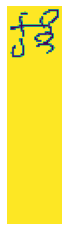

true label đã
predicted đã 



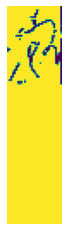

true label tế
predicted vế 



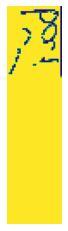

true label bắt
predicted bắi 



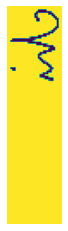

true label chi
predicted chi 



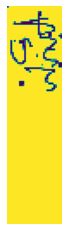

true label tĩnh
predicted tình 



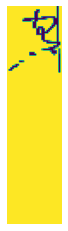

true label trí
predicted trí 



In [ ]:
for index in range (20):
    i = random.randint(0, len(X_valid))
    plt.imshow(np.squeeze(X_valid[i,:,:,]))
    plt.axis('off')
    plt.show()
    print ('true label',y_valid[i])
    print ('predicted',prediction[i],'\n')